# 2. Create videos

This tutorial demonstrates how to generate fluorescence microscopy videos of the AnDi trajectories using the function `transform_to_video`.

## 1. Setup
Importing the dependencies needed to run this tutorial.

In [ ]:
import numpy as np
import random
import imageio
import matplotlib.pyplot as plt
import deeptrack as dt
from andi_datasets.models_phenom import models_phenom

/opt/miniconda3/envs/handi/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/miniconda3/envs/handi/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2024-12-03 15:24:14.568472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Defining example diffusion model
As an example, We generate the trajectories of dimerization model from `models_phenom`.

### 2.1. Dimerization
Defining simulation parameters.

In [ ]:
T = 100 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> extending fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [ ]:
trajs, labels = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

Plotting trajectories.

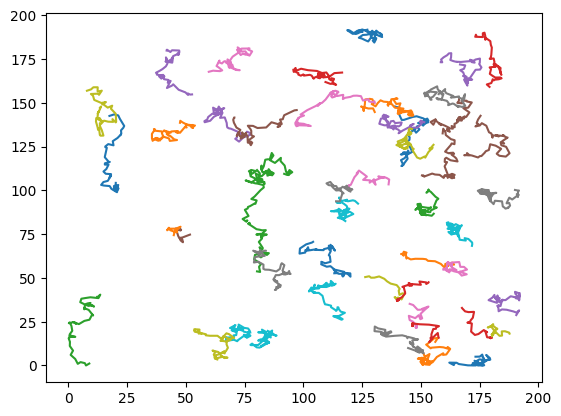

In [ ]:
for traj in np.moveaxis(trajs, 0, 1):
    plt.plot(traj[:,0], traj[:,1])
plt.show()

## 3. Generating videos


### 3.1. Import functions
For generating videos we import `transform_to_video` function from `andi_datasets` package. Additionally we import `play_video` function to display the videos within the jupyter notebook.

In [ ]:
from andi_datasets.utils_videos import transform_to_video, play_video

### 3.2. Usage
The trajectory data generated can be directly passed through `transform_to_video` to generate fluorescence videos of the particles.

#### 3.2.1. Generating a sample video

In [ ]:
video = transform_to_video(
    trajs,
)

In [ ]:
play_video(video)

By default, `transform_to_video` function generates video like above. However, the features of the video can be easily controlled with the help of the dictionaries: `particle_props`, `optics_props`, and `background_props`. For detailed information about the dictionaries and the inputs they can take, please refer to the documentation of `transform_to_video`.

We will some example use cases of dictionaries below.

#### 3.2.2. Controlling the noise
The noise in the videos can be controlled by adjusting the particle intensities in `particle_props`, and background intensity in `background_props`. We generate two videos in the following cell with low noise and high noise by controlling the particle intensity, for a fixed background intensity.

In [ ]:
# low noise video
low_noise_video = transform_to_video(
    trajs,
    particle_props={
        "particle_intensity": [1000, 0]
    },
    background_props={
        "background_mean": 100
    },
)

# high noise video
high_noise_video = transform_to_video(
    trajs,
    particle_props={
        "particle_intensity": [300, 0]
    },
    background_props={
        "background_mean": 100
    },
)

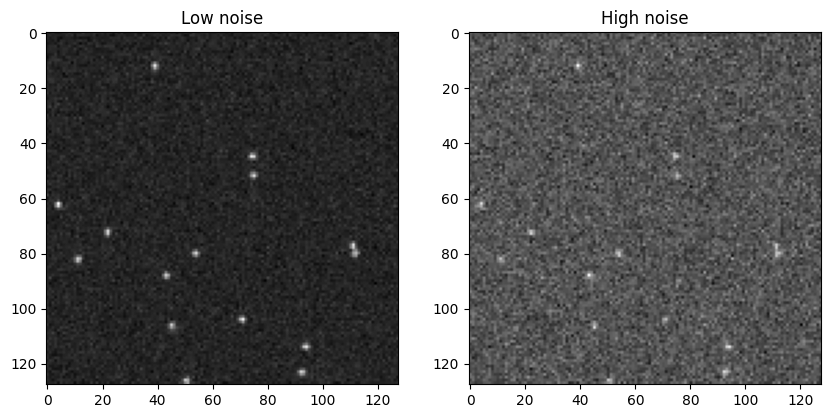

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(low_noise_video[0], cmap="gray")
ax0.set_title("Low noise")
ax1.imshow(high_noise_video[0], cmap="gray")
ax1.set_title("High noise")
plt.show()

#### 3.2.3. Controlling the output region
If you notice, the size of the video is always restricted to 128 x 128 px by default, while the trajectories are spread out in a larger area as per our definition of the length of the box above (Defined by simulation parameter, L). In this case, L was defined to be 1.5 * 128.

The output region of the video can be controlled in the `optics_props`. In the following cell, we generate the same low noise video as above but with a different region of interest (ROI). We shift the origin from `[0, 0]` to `[30, 30]`, while maintaining the width and height to 128 px as before.

In [ ]:
video_ROI = transform_to_video(
    trajs,
    particle_props={
        "particle_intensity": [1000, 0]
    },
    background_props={
        "background_mean": 100
    },
    optics_props={
        "output_region" : [30, 30, 30 + 128, 30 + 128] # [x, y, x + width, y + height]
    }
)

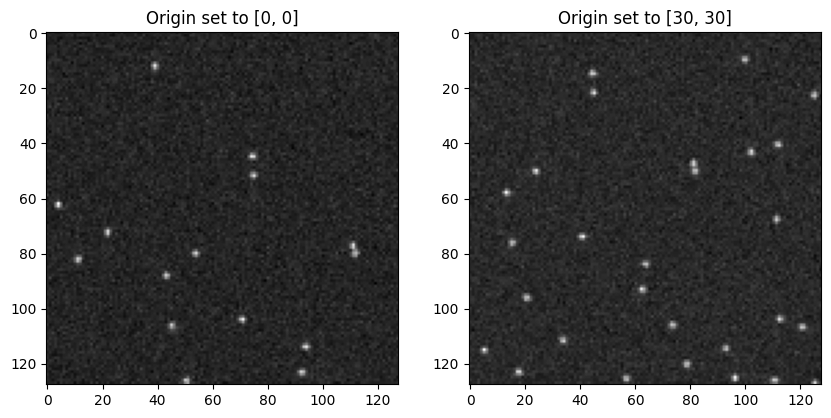

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(low_noise_video[0], cmap="gray")
ax0.set_title("Origin set to [0, 0]")
ax1.imshow(video_ROI[0], cmap="gray")
ax1.set_title("Origin set to [30, 30]")
plt.show()

## 4. Generating particle masks
The `transform_to_video` function can generate the particle masks along with the videos.

### 4.1. All particle masks
By setting the parameter `with_masks = True`, one can generate videos and masks simultaneously. The pixel values in the masks indicate the particle numbers.

In [ ]:
video, masks = transform_to_video(
    trajs,
    with_masks=True
)

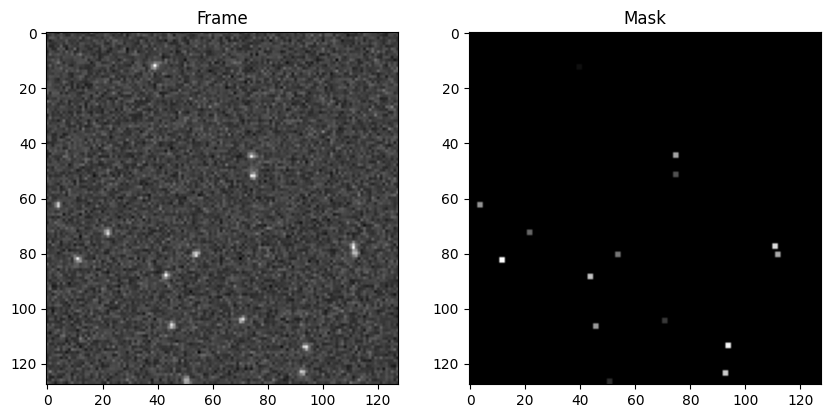

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(video[0], cmap="gray")
ax0.set_title("Frame")
ax1.imshow(masks[0], cmap="gray")
ax1.set_title("Mask")
plt.show()

### 4.2. VIP particle masks
By giving a list of particle numbers to `get_vip_particles`, one can restrict the masks to contain the only the vip particles. 

In [ ]:
vip_particles = random.sample(range(10, 50), 10)
video, masks = transform_to_video(
    trajs,
    optics_props= {
        "output_region": [0, 0, 200, 200]
    },
    get_vip_particles=vip_particles,
    with_masks=True
)

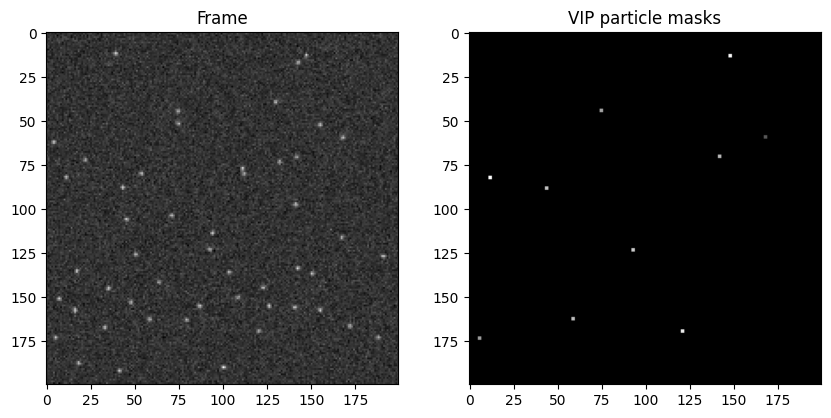

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(video[0], cmap="gray")
ax0.set_title("Frame")
ax1.imshow(masks[0], cmap="gray")
ax1.set_title("VIP particle masks")
plt.show()

### 4.3. Special case
If `get_vip_particles` is a non-empty list, and `with_masks` is set to `False` (Default), then the output will still be a video, However, the first frame of the video now contains the masks of vip particles in the first frame.

In [ ]:
vip_particles = random.sample(range(10, 50), 10)
video = transform_to_video(
    trajs,
    optics_props= {
        "output_region": [0, 0, 200, 200]
    },
    get_vip_particles=vip_particles,
    with_masks=False # Default
)

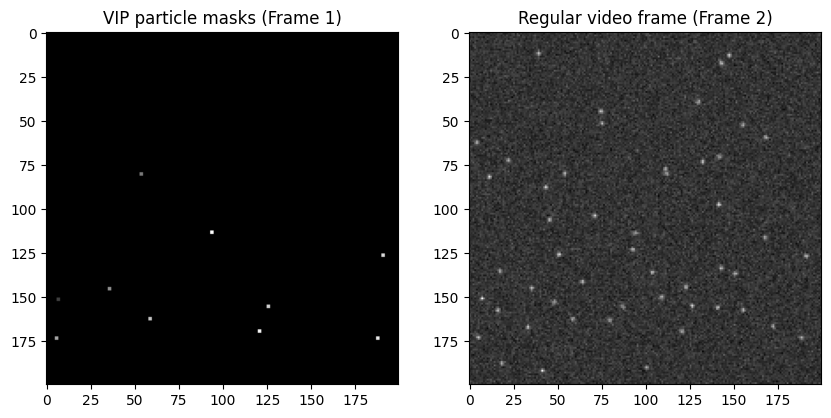

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(video[0], cmap="gray")
ax0.set_title("VIP particle masks (Frame 1)")
ax1.imshow(video[1], cmap="gray")
ax1.set_title("Regular video frame (Frame 2)")
plt.show()

## 5. Saving the videos
Videos can be saved by setting `save_video` to `True`, and providing a `path`. Alternatively, the videos can be directly saved as numpy arrays using `np.save(...)`.

In [ ]:
video = transform_to_video(
    trajs,
    save_video=True,
    path="../Test_video.tiff"
)

## 6. Generating videos with motion blur
We can generate videos with motion blur by creating a instance of `motion_blur` class and passing it to `transform_to_video` function as a parameter.

In [ ]:
from andi_datasets.utils_trajectories import motion_blur

Generate oversampled trajectories

In [ ]:
output_length = 50
oversamp_factor = 10
exposure_time = 0.2

T = output_length * oversamp_factor # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1* 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)


trajs_test, labels = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[1 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

print(trajs_test.shape)

(500, 50, 2)


Initiate motion blur class with defined parameters

In [ ]:
MB = motion_blur(output_length = output_length, oversamp_factor = oversamp_factor, exposure_time = exposure_time)

Pass the trajectory data and motion blur instance to `transform_to_video` function

In [ ]:
video = transform_to_video(
    trajs_test,
    motion_blur_generator=MB,
)

In [ ]:
play_video(video)

Saving videos with VIP particles in the first frame

In [ ]:
trajs_test, _ = models_phenom().single_state(N = 260, T = 5, L = 128, Ds = 1)
video = transform_to_video(
    trajs_test,
    with_masks=False,
    get_vip_particles=[1, 2, 3, 256, 257, 258],
    save_video = True,
    path='video_test.tiff'   
)